# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [4]:
prcAll = loadPrices('prices.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [5]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    for ma in [5]:
        for stock_i in range(nInst+1):
            log_return_df[f'forward_{ma}_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma)).shift(-ma)
            log_return_df[f'close_to_close (t-{ma})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma))
            
    # for ma in [1, 5]:
    #     for stock_i in range(nInst):
    #         for stock_j in range(stock_i+1, nInst):
    #             log_return_df[f'diff_forward_{ma}_{stock_i}_{stock_j}'] = log_return_df[f'forward_{ma}_{stock_i}'] - log_return_df[f'forward_{ma}_{stock_j}']
                # log_return_df[f'diff_close_to_close (t-{ma})(t0)_'+str(stock_i)+'_'+str(stock_j)] = log_return_df[f'close_to_close (t-{ma})(t0)_{stock_i}'] - log_return_df[f'close_to_close (t-{ma})(t0)_{stock_j}']

    return log_return_df

In [6]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    # for stock_id in range(nInst+1):
        # create lags
        # log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        
        # create MA
        # log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        # log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        # log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)

    log_return_df.rename(columns={stock_id:str(stock_id) for stock_id in range(nInst+1)}, inplace=True)
        
    
    return log_return_df

In [7]:
log_return_df = feature_engineer(prcAll)

In [8]:
# TRAIN_LENGTH = 250
# TEST_LENGTH = 50
# FIRST_TEST_DATE = 250

# features = ['close_to_close (t-5)(t0)']
# target_column = 'diff_forward_5_'

In [9]:
# todo: class this

def build_univariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)
        
    # build models
    model = OLS(y, X).fit()

    return model

def inference_univariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_univariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [10]:
def build_multivariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_multivariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]
    if target_stock == feature_stock:
        X = log_return_df[[f'{_}_{target_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_multivariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [11]:
# good_model_dict = defaultdict(dict)
# model_accuracy_dict = defaultdict(dict)
# model_features_dict = defaultdict(dict)

# for i in tqdm(range(NUM_STOCKS+1)):
#     for j in range(NUM_STOCKS+1):

#         ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH)
#         ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH)

#         if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
#             good_model_dict[i][j] = ma_model
#             model_features_dict[i][j] = features
#             model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

# final_model = defaultdict(dict)

# for stock_i in model_accuracy_dict:
#     top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
#     for stock_j, score in top_10:

#         if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
#             final_model[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

In [12]:
# for stock_i in final_model:
#     print(stock_i, final_model[stock_i].keys())

# Backtest

## Define Strategy

In [13]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(NUM_STOCKS+1):
            
            if BACKBONE_MODEL == 'univariate':
                ma_model = build_univariate_linear_regression(log_return_df, i, j, features, first_start_date, TRAIN_LENGTH)
                ma_y, ma_pred = predict_train_univariate(log_return_df, ma_model, i, j, features, first_start_date, TRAIN_LENGTH)
                if abs(ma_model.tvalues.values[0]) >= 2:
                    good_model_dict[i][j] = ma_model
                    model_features_dict[i][j] = features
                    model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

            elif BACKBONE_MODEL == 'multivariate':
                ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, first_start_date, TRAIN_LENGTH)
                ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, first_start_date, TRAIN_LENGTH)

                if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                    good_model_dict[i][j] = ma_model
                    model_features_dict[i][j] = features
                    model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

In [14]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date, replicate_newPos
    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        #TODO
        replicate_newPos = np.zeros(nInst)

        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
        # old_model_dict = final_model_dict
        
    # make predictions
    for stock_i in final_model_dict:
        stock_i_predictions_list = []
        for stock_j in final_model_dict[stock_i]:
            if BACKBONE_MODEL == 'univariate':
                stock_i_predictions_list.append(inference_univariate_linear_regression(log_return_df,
                                       final_model_dict[stock_i][stock_j],
                                       stock_i,
                                       stock_j,
                                       model_features_dict[stock_i][stock_j],
                                       first_start_date,
                                       TRAIN_LENGTH))
            elif BACKBONE_MODEL == 'multivariate':
                stock_i_predictions_list.append(inference_multivariate_linear_regression(log_return_df,
                                        final_model_dict[stock_i][stock_j],
                                        stock_i,
                                        stock_j,
                                        model_features_dict[stock_i][stock_j],
                                        first_start_date,
                                        TRAIN_LENGTH))
        stock_i_prediction = np.sum([np.sign(x) for x in stock_i_predictions_list])

        signals[stock_i, prcSoFar.shape[1]-START_DATE] = stock_i_prediction

        if stock_i_prediction > 0:
            if currentPos[stock_i] >= 0:
                currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
            else:
                currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif stock_i_prediction < -0:
            if currentPos[stock_i] <= 0:
                currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
            else:
                currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
        else:
            no_signal += 1
        total_signals += 1

        replicate_newPos[stock_i] = currentPos[stock_i]
        replicate_newPos[stock_i] = np.clip(replicate_newPos[stock_i], int(-10000/prcSoFar[stock_i, -1]), int(10000/prcSoFar[stock_i, -1]))

    return currentPos

## Run

In [15]:
BACKBONE_MODEL = 'multivariate'

TRAIN_LENGTH = 250
TEST_LENGTH = 250

features = ['close_to_close (t-5)(t0)']
target_column = ''

In [16]:
START_DATE = 250

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])
no_signal = 0
total_signals = 0

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -27.00 todayPL: $-27.00 $-traded: 27000 return: -0.00100
Day 251 value: -79.87 todayPL: $-52.87 $-traded: 57000 return: -0.00140
Day 252 value: -72.83 todayPL: $7.04 $-traded: 84000 return: -0.00087
Day 253 value: -174.53 todayPL: $-101.70 $-traded: 111000 return: -0.00157
Day 254 value: -379.80 todayPL: $-205.27 $-traded: 137000 return: -0.00277
Day 255 value: -464.86 todayPL: $-85.06 $-traded: 164000 return: -0.00283
Day 256 value: -427.60 todayPL: $37.25 $-traded: 189000 return: -0.00226
Day 257 value: -473.12 todayPL: $-45.52 $-traded: 216000 return: -0.00219
Day 258 value: -701.19 todayPL: $-228.06 $-traded: 242000 return: -0.00290
Day 259 value: -544.67 todayPL: $156.51 $-traded: 267589 return: -0.00204
Day 260 value: -705.13 todayPL: $-160.46 $-traded: 285745 return: -0.00247
Day 261 value: -290.76 todayPL: $414.37 $-traded: 304864 return: -0.00095
Day 262 value: -241.83 todayPL: $48.93 $-traded: 324023 return: -0.00075
Day 263 value: -197.16 todayPL: $44.67 $-tra

In [17]:
const = 249
df_rows = []
for STOCK in range(nInst):

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
audit_df.to_excel('audit_table_250.xlsx')

In [ ]:
START_DATE = 500

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 500 value: -30.00 todayPL: $-30.00 $-traded: 30000 return: -0.00100
Day 501 value: -31.28 todayPL: $-1.28 $-traded: 61000 return: -0.00051
Day 502 value: -64.69 todayPL: $-33.41 $-traded: 93000 return: -0.00070
Day 503 value: 10.04 todayPL: $74.73 $-traded: 124000 return: 0.00008
Day 504 value: 109.96 todayPL: $99.92 $-traded: 156000 return: 0.00070
Day 505 value: 55.46 todayPL: $-54.50 $-traded: 187000 return: 0.00030
Day 506 value: 260.30 todayPL: $204.85 $-traded: 216000 return: 0.00121
Day 507 value: 256.12 todayPL: $-4.19 $-traded: 248000 return: 0.00103
Day 508 value: -59.05 todayPL: $-315.17 $-traded: 280000 return: -0.00021
Day 509 value: -260.63 todayPL: $-201.57 $-traded: 310705 return: -0.00084
Day 510 value: -543.79 todayPL: $-283.16 $-traded: 329948 return: -0.00165
Day 511 value: -495.91 todayPL: $47.87 $-traded: 349260 return: -0.00142
Day 512 value: -283.29 todayPL: $212.62 $-traded: 366753 return: -0.00077
Day 513 value: -325.84 todayPL: $-42.55 $-traded: 386101 re

In [ ]:
const = 249+250
df_rows = []

for STOCK in range(nInst):

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
audit_df.to_excel('audit_table_500.xlsx')

In [ ]:
START_DATE = 750

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(750, 1001): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

In [ ]:
const = 249+500

df_rows = []

for STOCK in range(nInst):

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
audit_df.to_excel('audit_table_750.xlsx')

# Evaluation

In [ ]:
# returns_flatten = returns[:250].flatten()
# signals_flatten = signals[:250].flatten()

# buckets = {}
# for i in range(-51, 51, 5):
#     buckets[(i, i+1)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i and signals_flatten[j] < i+1]
# buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# # Extract the mid-point of each bucket range and the mean returns
# bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
# bucket_means = [value for key, value in buckets]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(bucket_midpoints, bucket_means, color='blue')
# plt.xlabel('Signal Buckets Midpoints')
# plt.ylabel('Mean Returns')
# plt.axvline(x=0, color='r', linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
# plt.title('Mean Returns per Signal Bucket')
# plt.grid(True)
# plt.show()

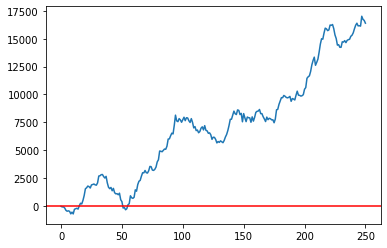

In [ ]:
plt.plot(np.cumsum(pll))
plt.axhline(y=0, color='r', linestyle='-')

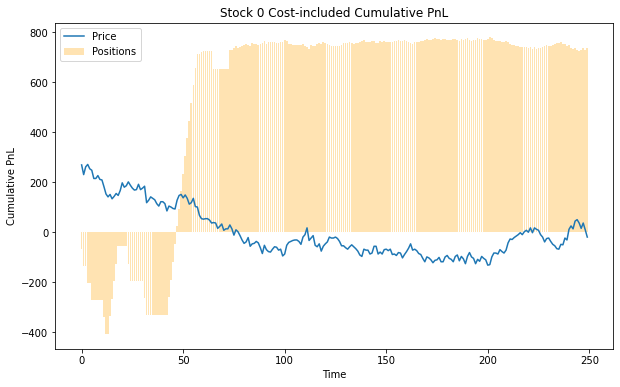

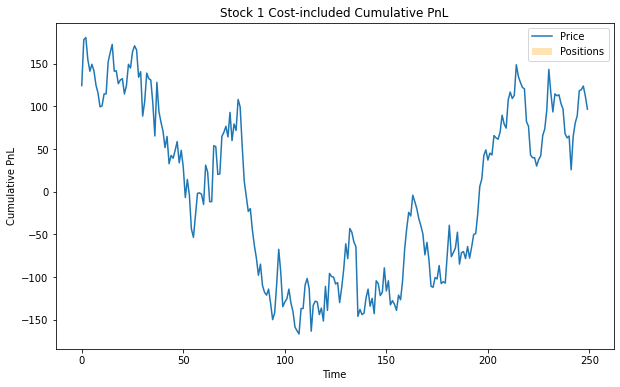

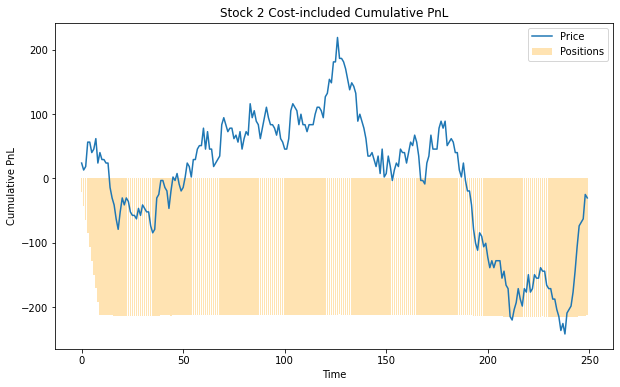

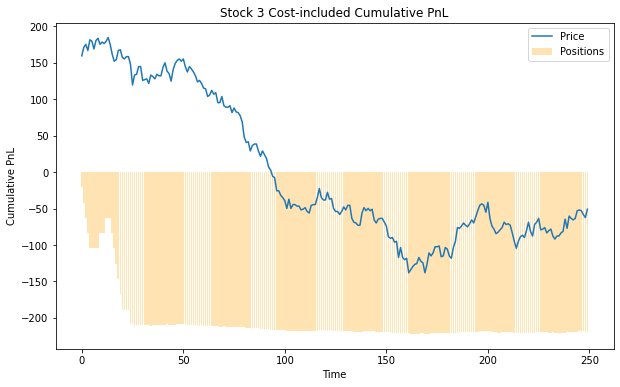

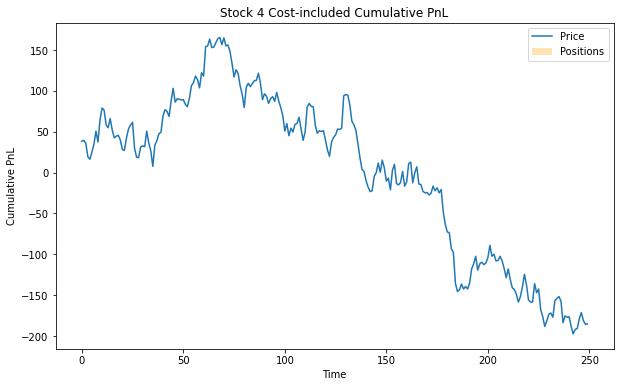

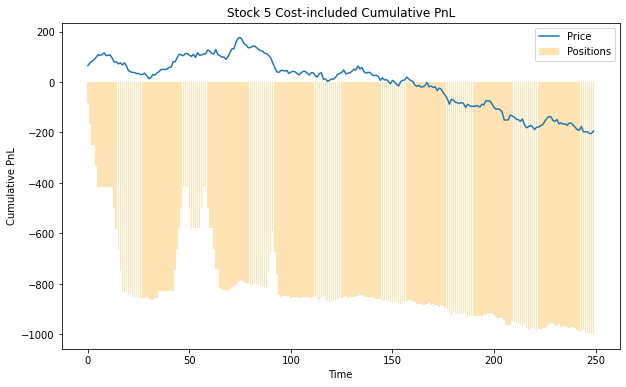

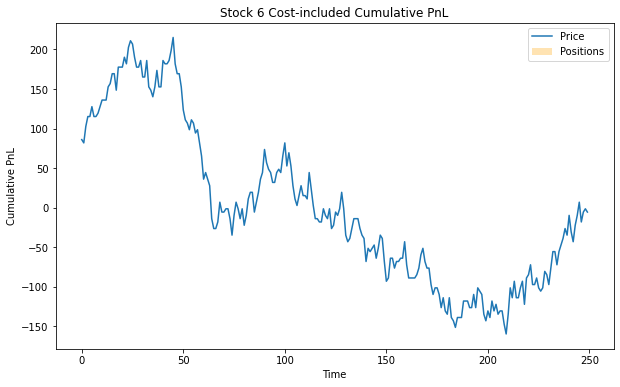

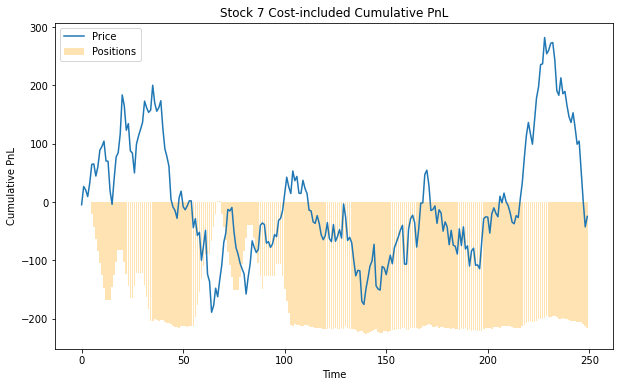

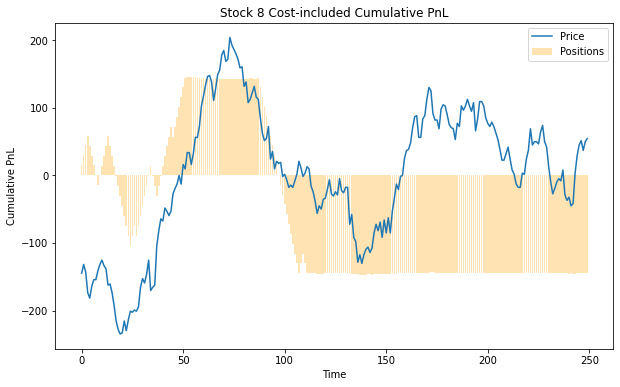

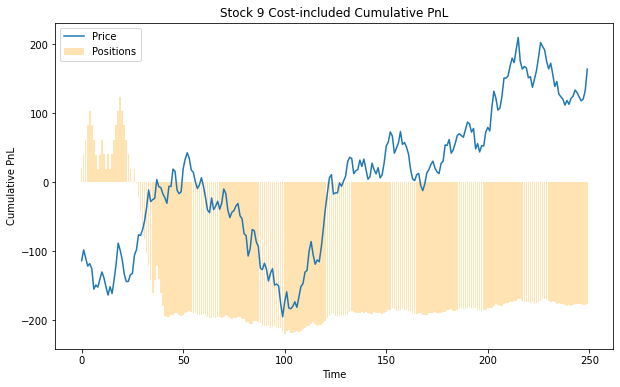

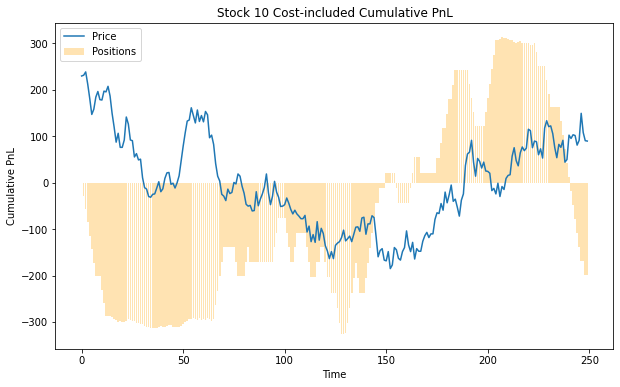

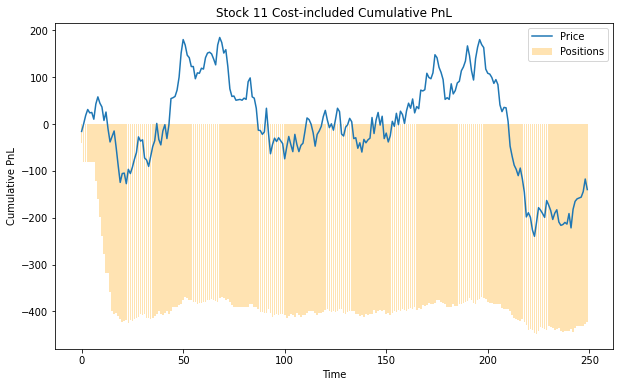

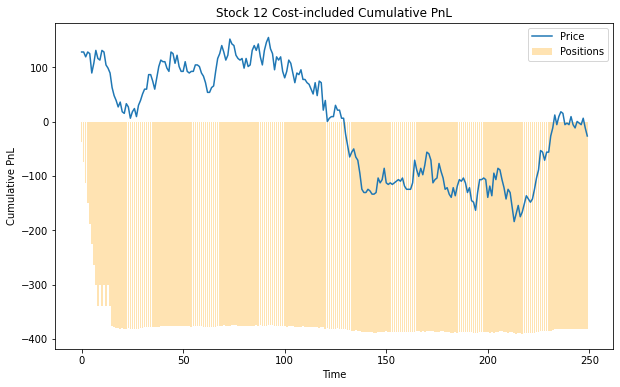

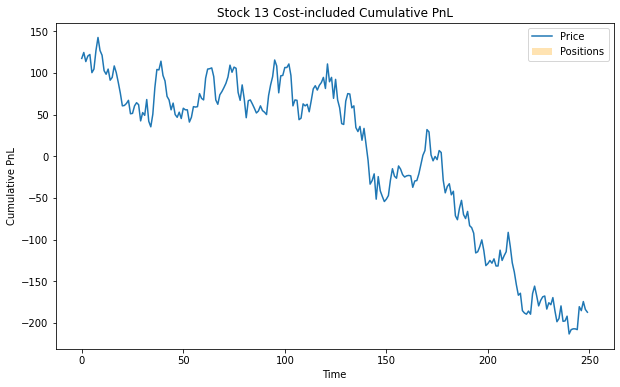

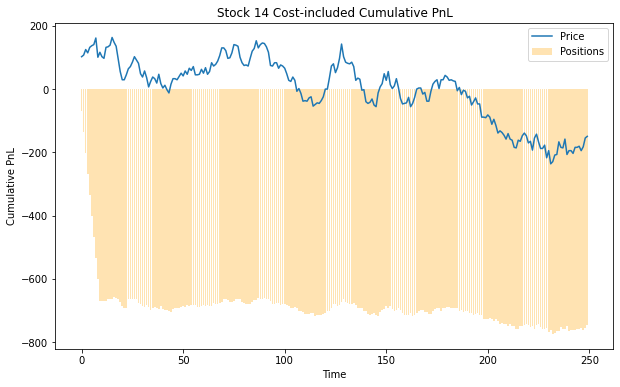

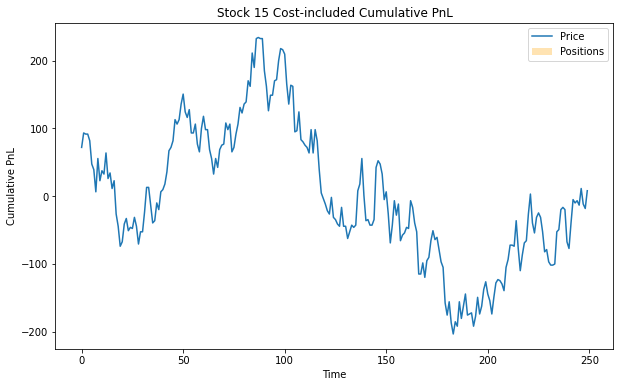

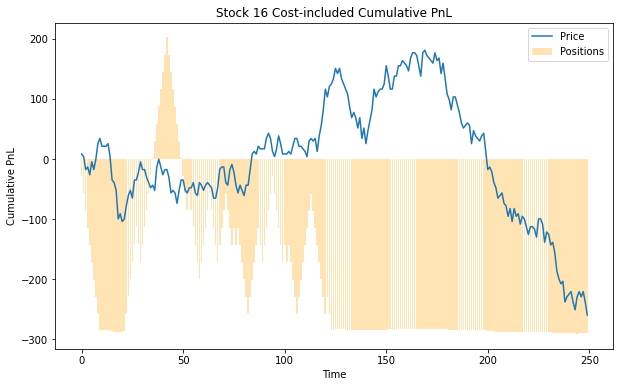

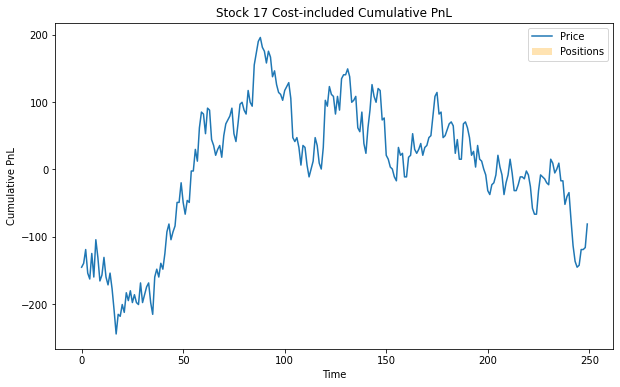

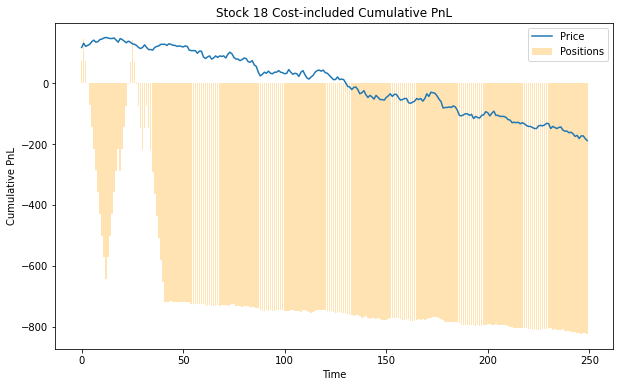

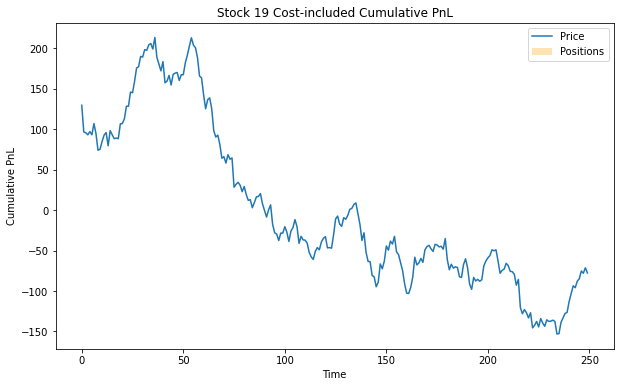

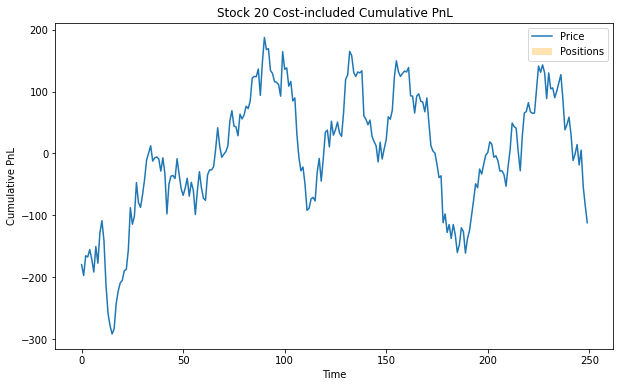

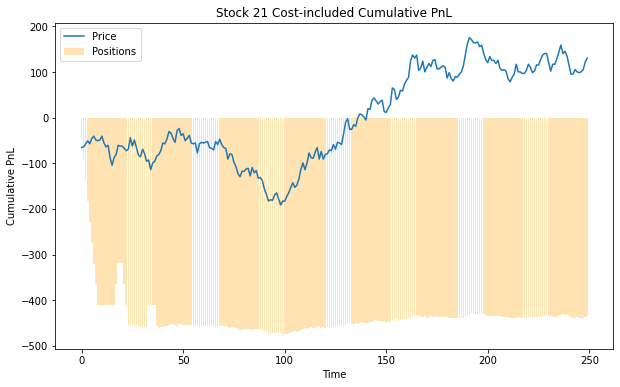

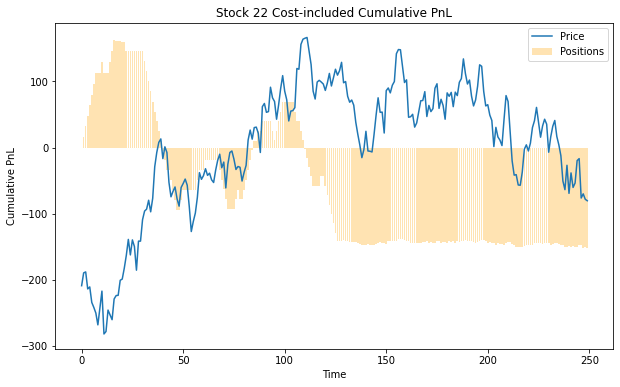

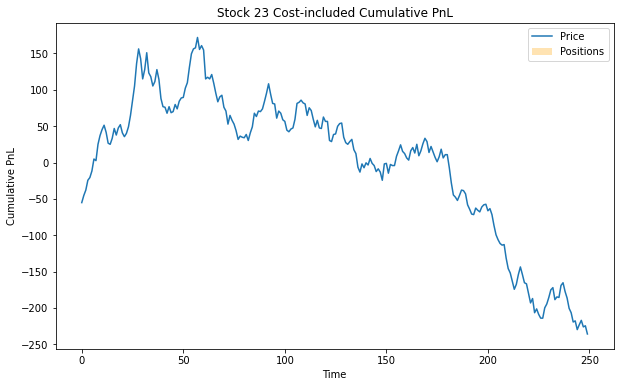

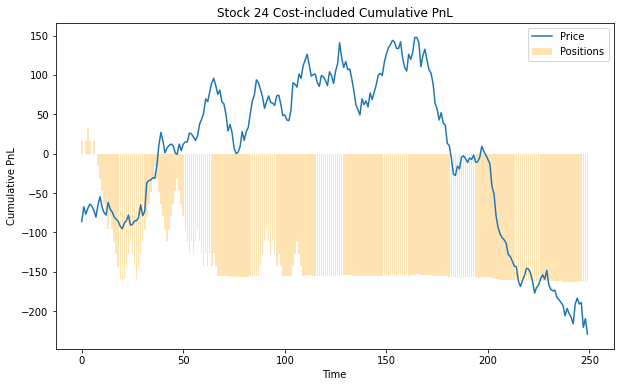

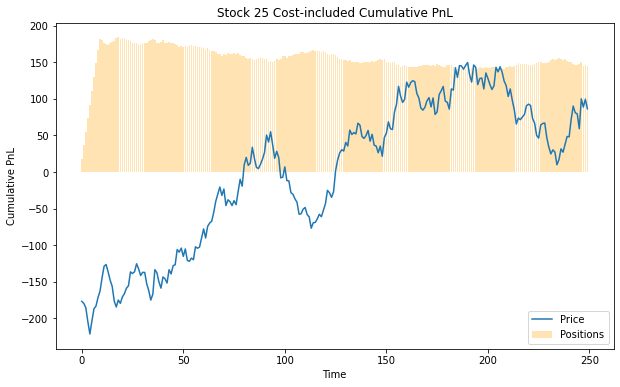

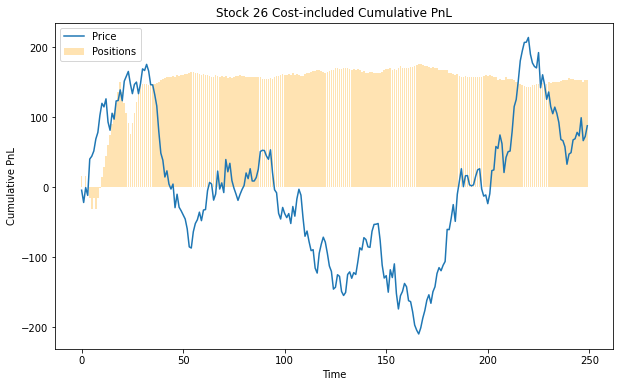

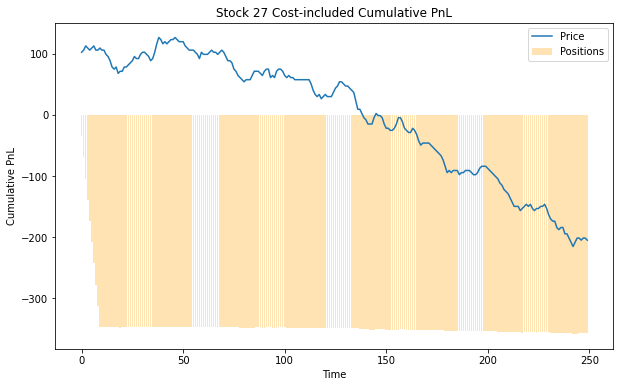

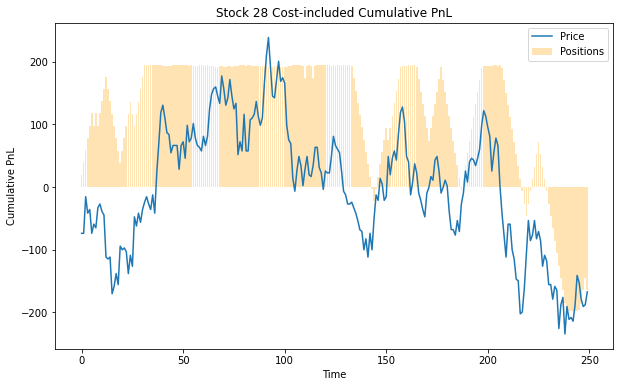

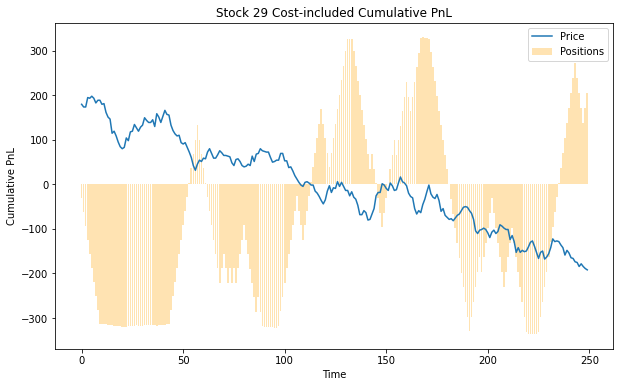

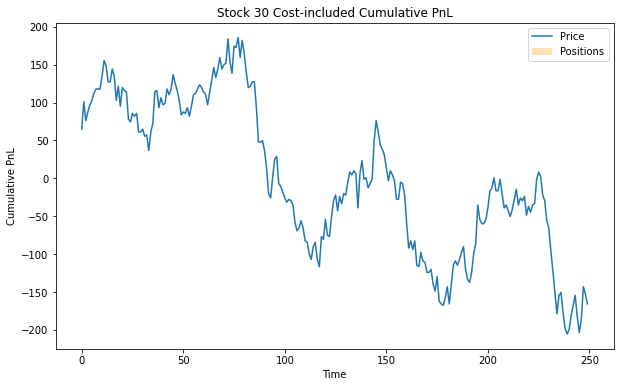

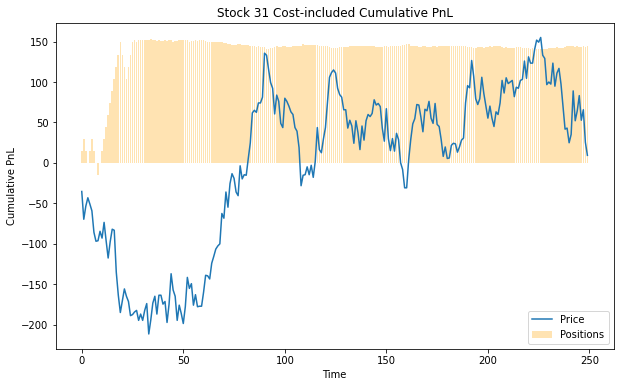

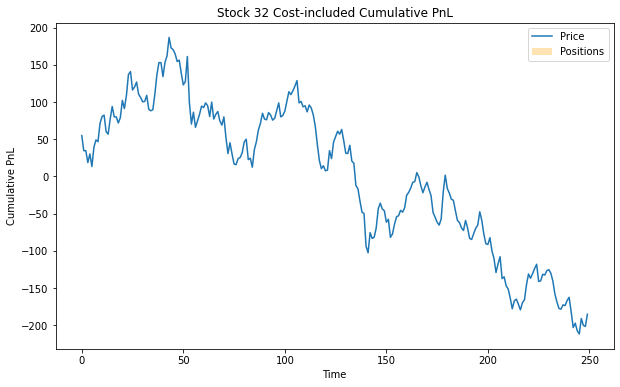

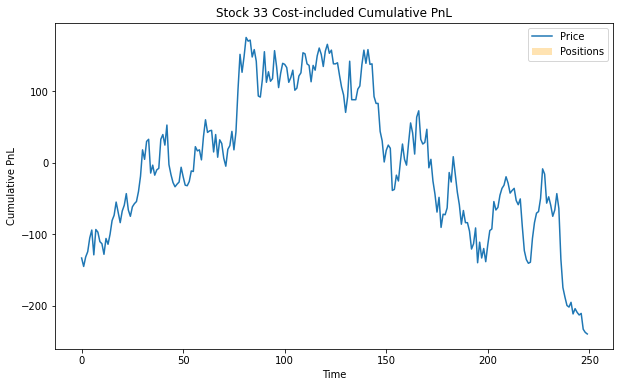

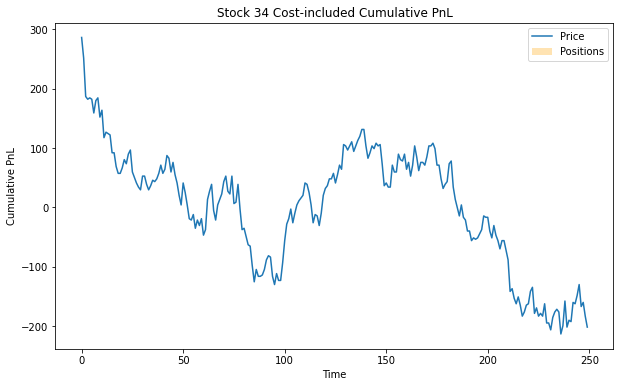

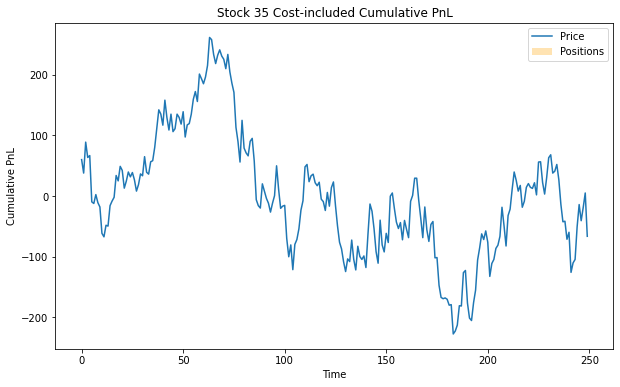

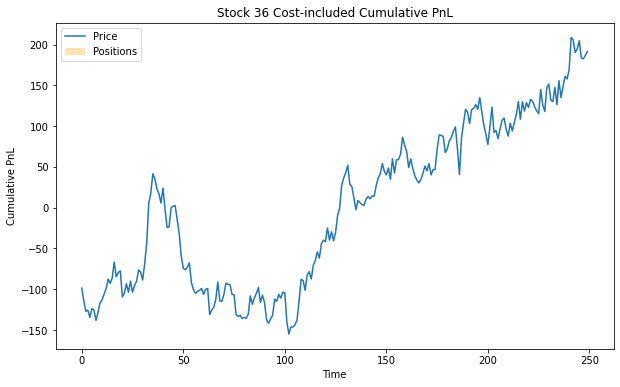

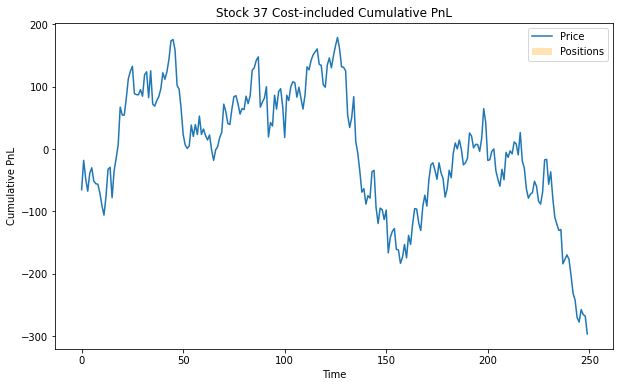

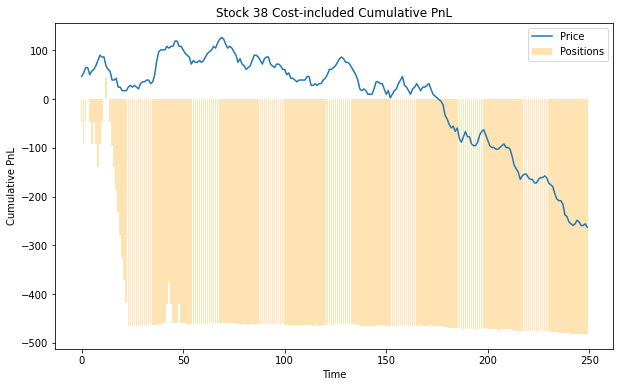

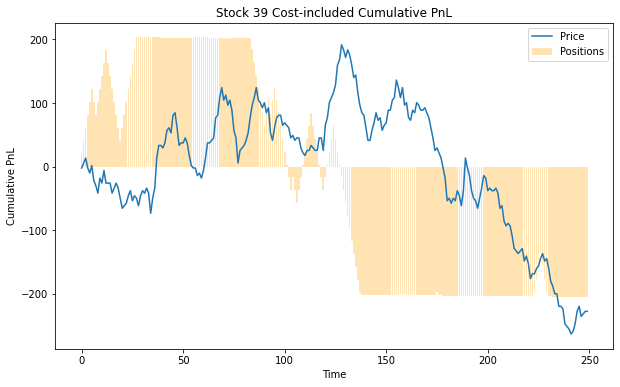

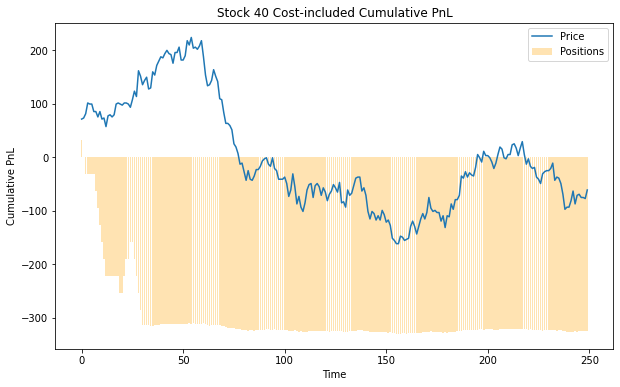

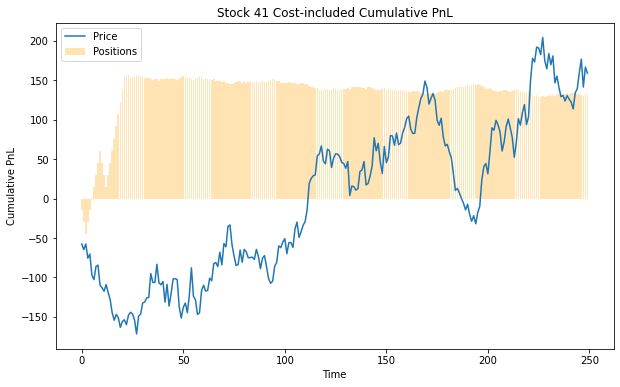

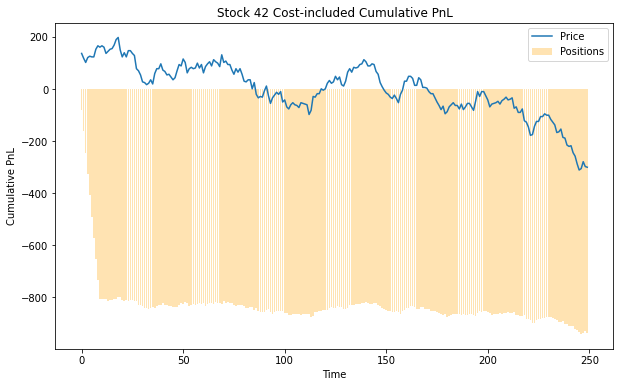

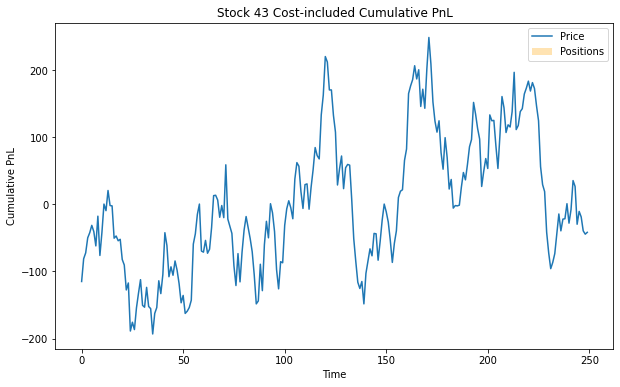

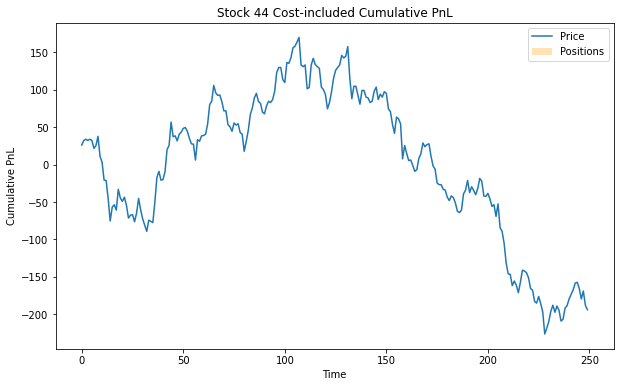

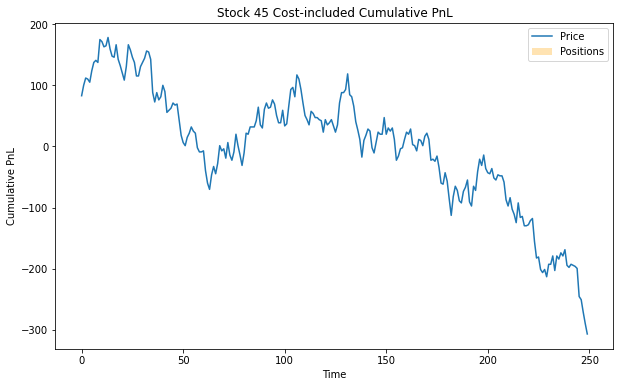

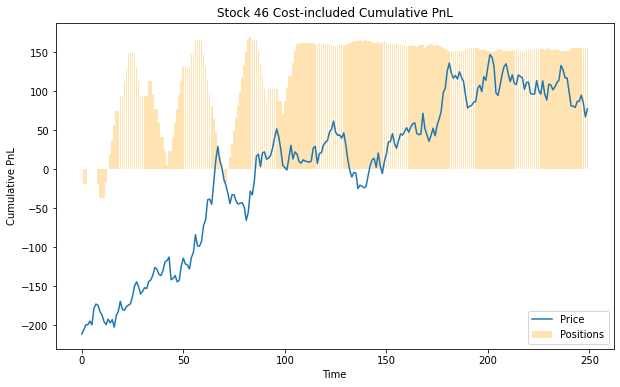

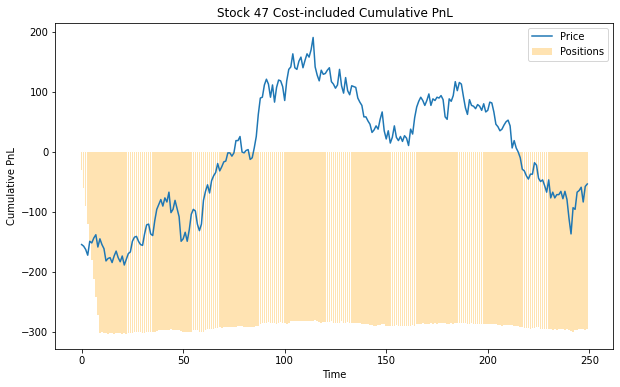

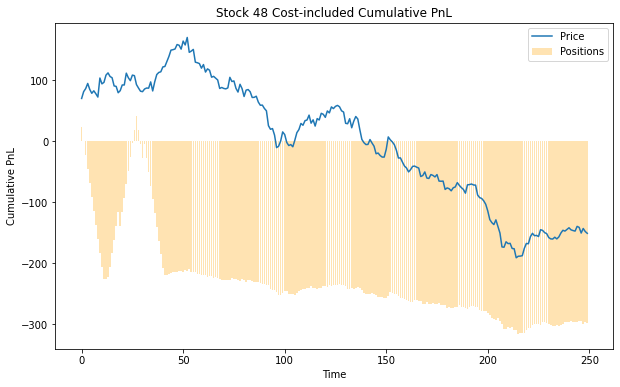

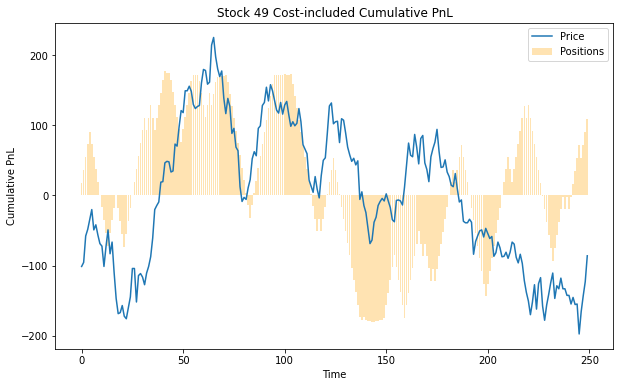

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()


# Graveyard

##### Difference

In [ ]:
def build_difference_linear_regression(log_return_df, target_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_difference_linear_regression(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_difference(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [ ]:
good_model_dict = defaultdict(dict)
model_accuracy_dict = defaultdict(dict)
model_features_dict = defaultdict(dict)

for i in tqdm(range(NUM_STOCKS)):
    for j in range(i+1, NUM_STOCKS):

        ma_model = build_difference_linear_regression(log_return_df, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)
        ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)

        if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
            good_model_dict[i][j] = ma_model
            model_features_dict[i][j] = features
            model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'FIRST_TEST_DATE' is not defined

In [ ]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(i+1, NUM_STOCKS):
            
            ma_model = build_difference_linear_regression(log_return_df, [i, j], features, first_start_date, TRAIN_LENGTH)
            ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, first_start_date, TRAIN_LENGTH)

            if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = features
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

In [ ]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date

    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
        # old_model_dict = final_model_dict
    
    signal = np.zeros(50)

    # make predictions
    for stock_i in final_model_dict:
        for stock_j in final_model_dict[stock_i]:
            
            stock_i_j_prediction = inference_difference_linear_regression(log_return_df,
                                    final_model_dict[stock_i][stock_j],
                                    [stock_i,
                                    stock_j],
                                    model_features_dict[stock_i][stock_j],
                                    first_start_date,
                                    TRAIN_LENGTH)

            if stock_i_j_prediction > 0: 
                signal[stock_i] += 1
                signal[stock_j] -= 1
            elif stock_i_j_prediction < 0:
                signal[stock_i] -= 1
                signal[stock_j] += 1
     

    for stock_i in final_model_dict:
        if signal[stock_i] > 0:
            currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif signal[stock_i] < -0:
            currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
        
    return currentPos